<center>
<a href="https://colab.research.google.com/drive/18uxa0ZMlck4f5fzTUdkze_cuKz-Hgx_o?usp=sharing"> <img align="center" src="https://colab.research.google.com/assets/colab-badge.svg"> </a></center>

## Installing Packages

Run this cell only if torchtext reports an error while importing bleu_score.

In [ ]:
!pip install torchtext==0.6.0

##Importing Required Libraries




In [ ]:
from google.colab import drive
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random
import spacy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Notebook is running on", device)

Notebook is running on cuda


Fixing SEED for reproducibility of results

In [ ]:
SEED = 4444

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Fetching Spacy Models

In [ ]:
!python -m spacy download de
!python -m spacy download en

     |████████████████████████████████| 14.9MB 1.3MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=628a873bfdd1d4beed92e4382e15fc102056b5c196855f0a4c844b4d36b64174
  Stored in directory: /tmp/pip-ephem-wheel-cache-l06i44h6/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## Helper Objects and Functions

In [ ]:
de_model = spacy.load('de')
en_model = spacy.load('en')

In [ ]:
def de_tokenizer(sentence):
    return [token.text for token in de_model.tokenizer(sentence)]

def en_tokenizer(sentence):
    return [token.text for token in en_model.tokenizer(sentence)]

In [ ]:
SOURCE_Field = Field(eos_token = '<src_eos>', init_token = '<src_sos>', lower = True, tokenize = de_tokenizer, batch_first = True)

TARGET_Field = Field(eos_token = '<trg_eos>', init_token = '<trg_sos>', lower = True, tokenize = en_tokenizer, batch_first = True)

A helper function to return input tensor corresponding to any string or list of tokens.

In [ ]:
def ipTensor(sentence, src_field):
    if isinstance(sentence, list):
        tokens = [src_field.init_token] + [token.lower() for token in sentence] + [src_field.eos_token]
    else:
        tokens = [src_field.init_token] + de_tokenizer(sentence) + [src_field.eos_token]
    seq_len = len(tokens)
    ip_tensor = torch.LongTensor([src_field.vocab.stoi[token] for token in tokens]).to(device)
    return ip_tensor.view(1, seq_len)

## Fetching and Splitting Data

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SOURCE_Field, TARGET_Field))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 530kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 151kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 147kB/s]


In [ ]:
SOURCE_Field.build_vocab(train_data, min_freq = 2)
TARGET_Field.build_vocab(train_data, min_freq = 2)

In [ ]:
print(f"Source vocab size: {len(SOURCE_Field.vocab)} | Target vocab size: {len(TARGET_Field.vocab)}")

Source vocab size: 7855 | Target vocab size: 5893


## Model Definition

In [ ]:
class Encoder(nn.Module):
    def __init__(self, tok_vocab_size, pos_vocab_size, embedding_dim, hidden_dim, kernel_size, num_layers, enc_dropout):
        super(Encoder, self).__init__()
        self.tok_embedding = nn.Embedding(tok_vocab_size, embedding_dim)
        self.pos_embedding = nn.Embedding(pos_vocab_size, embedding_dim)
        self.emb2hid = nn.Linear(embedding_dim, hidden_dim)
        self.hid2emb = nn.Linear(hidden_dim, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hidden_dim,
                                              out_channels = 2*hidden_dim,
                                              kernel_size = kernel_size,
                                              padding = (kernel_size-1)//2) for i in range(num_layers)])
        self.dropout = nn.Dropout(enc_dropout)
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)

    def forward(self, input):                                                               # [input] = [batch_size, src_len]
        batch_size = input.shape[0]                                
        seq_len = input.shape[1]
        tok_embed = self.tok_embedding(input)                                               # [tok_embed] = [batch_size, src_len, embedding_dim]
        pos_tensor = torch.arange(0,seq_len).unsqueeze(0).repeat(batch_size, 1).to(device)  # [pos_tensor] = [batch_size, src_len]
        pos_embed = self.pos_embedding(pos_tensor)                                          # [pos_embed] = [batch_size, src_len, embedding_dim]             
        enc_embed = self.dropout(tok_embed + pos_embed)                                     # [enc_embed] = [batch_size, src_len, embedding_dim]
        enc_conv_input = self.emb2hid(enc_embed).permute(0, 2, 1)                           # [enc_conv_input] = [batch_size, hidden_dim, src_len]
        for conv_layer in self.convs:
            enc_conved = conv_layer(self.dropout(enc_conv_input))                           # [enc_conved] = [batch_size, 2*hidden_dim, src_len]
            enc_conved = F.glu(enc_conved, dim = 1)                                         # [enc_conved] = [batch_size, hidden_dim, src_len]      
            enc_conved = (enc_conved + enc_conv_input)*self.scale               
            enc_conv_input = enc_conved                                                     # [enc_conv_input] = [batch_size, hidden_dim, src_len]   
        enc_conved = self.hid2emb(enc_conved.permute(0, 2, 1))                              # [enc_conved] = [batch_size, src_len, embedding_dim]
        enc_combined = (enc_conved + enc_embed)*self.scale                                  # [enc_combined] = [batch_size, src_len, embedding_dim] 
        return enc_conved, enc_combined

In [ ]:
class Decoder(nn.Module):
    def __init__(self, tok_vocab_size, pos_vocab_size, embedding_dim, hidden_dim, kernel_size, num_layers, dec_dropout, trg_pad_idx):
        super(Decoder, self).__init__()
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.tok_embedding = nn.Embedding(tok_vocab_size, embedding_dim)
        self.pos_embedding = nn.Embedding(pos_vocab_size, embedding_dim)
        self.emb2hid = nn.Linear(embedding_dim, hidden_dim)
        self.hid2emb = nn.Linear(hidden_dim, embedding_dim)
        self.attn_emb2hid = nn.Linear(embedding_dim, hidden_dim)
        self.attn_hid2emb = nn.Linear(hidden_dim, embedding_dim)
        self.fc = nn.Linear(embedding_dim, tok_vocab_size)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hidden_dim,
                                              out_channels = 2*hidden_dim,
                                              kernel_size = kernel_size) for i in range(num_layers)])
        self.dropout = nn.Dropout(dec_dropout)
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)

    def calc_attention(self, dec_embed, dec_conved, enc_conved, enc_combined):              # [dec_embed] = [batch_size, trg_len, embedding_dim] dec_conved = [batch_size, hidden_dim, trg_len] 
                                                                                            # [encoder_conved] = [encoder_combined] = [batch_size, src_len, embedding_dim]
        dec_conved_emb = self.attn_hid2emb(dec_conved.permute(0, 2, 1))                     # [dec_conved_emb] = [batch_size, trg_len, embedding_dim]
        dec_combined = (dec_embed + dec_conved_emb)*self.scale                              # [dec_combined] = [batch_szie, trg_len, embedding_len]
        energy = torch.matmul(dec_combined, enc_conved.permute(0, 2, 1))                    # energy = [batch_size, trg_len, src_len]
        attention = F.softmax(energy, dim = 2)                                              # attention = [batch_size, trg_len, src_len]
        attended_encoding = torch.matmul(attention, enc_combined)                           # attended_encoding = [batch_size, trg_len, embedding_dim]    
        attended_encoding = self.attn_emb2hid(attended_encoding)                            # attended_encoding = [batch_size, trg_len, hidden_dim]
        attended_combined = (attended_encoding.permute(0, 2, 1) + dec_conved)*self.scale    # attented_combined = [batch_size, hidden_dim, trg_len]
        return attention, attended_combined

    def forward(self, target, enc_conved, enc_combined):                                    # target = [batch_size, trg_len] encoder_conved = encoder_combined = [batch_size, src_len, embedding_dim]
        batch_size = target.shape[0]
        trg_len = target.shape[1]
        tok_embed = self.tok_embedding(target)                                              # tok_embed = [batch_size, trg_len, embedding_dim]
        pos_tensor = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(device) # pos_tensor = [batch_size, trg_len]
        pos_embed = self.pos_embedding(pos_tensor)                                          # pos_embed = [batch_size, trg_len, embedding_dim]
        dec_embed = self.dropout(tok_embed + pos_embed)                                     # dec_embed = [batch_size, trg_len, embedding_dim]
        dec_conv_input = self.emb2hid(dec_embed).permute(0, 2, 1)                           # dec_conv_input = [batch_size, hidden_dim, trg_len]
        hidden_dim = dec_conv_input.shape[1]
        for conv_layer in self.convs:
            padding = torch.zeros((batch_size, hidden_dim, self.kernel_size - 1)).fill_(self.trg_pad_idx).to(device) 
            padded_conv_input = torch.cat((padding, dec_conv_input), dim = 2)               # padded_conv_input = [batch_size, hidden_dim, trg_len+kernel_size-1]
            dec_conved = conv_layer(padded_conv_input)                                      # dec_conved = [batch_size, 2*hidden_dim, trg_len]
            dec_conved = F.glu(dec_conved, dim = 1)                                         # dec_conved = [batch_size, hidden_dim, trg_len]
            attention, dec_conved = self.calc_attention(dec_embed, dec_conved, enc_conved, enc_combined) # attention = [batch_size, trg_len, src_len] dec_conved = [batch_size, hidden_dim, trg_len]
            dec_conved = (dec_conved + dec_conv_input)*self.scale                           # dec_conved = [batch_size, hidden_dim, trg_len]
            dec_conv_input = dec_conved
        dec_conved = self.hid2emb(dec_conved.permute(0, 2, 1))                              # dec_conved = [batch_size, trg_len, embedding_dim]
        output = self.fc(self.dropout(dec_conved))                                          # output = [batch_size, trg_len, tok_vocab_size]
        return output, attention

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, source, target):                                                      # source = [batch_size, src_len] target = [batch_size, trg_len-1]
        enc_conved, enc_combined = self.encoder(source)
        output, attention = self.decoder(target, enc_conved, enc_combined)
        return output, attention

## Training and Evaluation Functions

In [ ]:
def Train(iterator, model, criterion, optimizer, clip=1):
    model.train()
    epoch_loss = 0
    for _, batch in enumerate(iterator):
        model.zero_grad()
        source = batch.src
        target = batch.trg
        outputs, _ = model(source, target[:, :-1])
        outputs = outputs.contiguous().view(-1, outputs.shape[-1])
        targets = target[:, 1:].contiguous().view(-1).to(device)
        # To avoid using .contiguous() simply use .reshape instead of .conti..().view()
        batch_loss = criterion(outputs, targets)
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += batch_loss.item()

    return epoch_loss/len(iterator)

In [ ]:
def Evaluate(iterator, model, criterion):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for _, batch in enumerate(iterator):
            source = batch.src
            target = batch.trg
            outputs, attention = model(source, target[:, :-1])
            outputs = outputs.contiguous().view(-1, outputs.shape[-1])
            targets = target[:, 1:].contiguous().view(-1).to(device)
            # To avoid using .contiguous() simply use .reshape instead of .conti..().view()
            batch_loss = criterion(outputs, targets)
            eval_loss += batch_loss.item()
        
        return eval_loss/len(iterator)

In [ ]:
def Epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return (elapsed_mins, elapsed_secs)

## Data Iterators, Hyperparameters and Model Initialization

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE, device = device)

In [ ]:
print("Number of Training sequences: ", len(train_data.examples))
print("Number of Test sequences: ", len(test_data.examples))
print("Number of Validation sequences: ", len(valid_data.examples))

Number of Training sequences:  29000
Number of Test sequences:  1000
Number of Validation sequences:  1014


In [ ]:
NUM_EPOCHS = 10
LR = 0.001
CLIP = 1
SRC_VOCAB_SIZE = len(SOURCE_Field.vocab)
TRG_VOCAB_SIZE = len(TARGET_Field.vocab)
HIDDEN_DIM = 512
EMBEDDING_DIM = 256
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
KERNEL_SIZE = 3
ENC_NUM_LAYERS = 10
DEC_NUM_LAYERS = 10
MAX_LEN = 100

In [ ]:
trg_padding_idx = TARGET_Field.vocab.stoi[TARGET_Field.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = trg_padding_idx)

In [ ]:
encoder = Encoder(SRC_VOCAB_SIZE, MAX_LEN, EMBEDDING_DIM, HIDDEN_DIM, KERNEL_SIZE, ENC_NUM_LAYERS, ENC_DROPOUT).to(device)
decoder = Decoder(TRG_VOCAB_SIZE, MAX_LEN, EMBEDDING_DIM, HIDDEN_DIM, KERNEL_SIZE, DEC_NUM_LAYERS, DEC_DROPOUT, trg_padding_idx).to(device)
seq2seq = Seq2Seq(encoder, decoder).to(device)
optimizer = optim.AdamW(seq2seq.parameters(), LR)

In [ ]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.xavier_uniform_(param.data)
        else:
            nn.init.constant(param.data, 0)

In [ ]:
seq2seq.apply(initialize_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  


Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,),

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters.')

The model has 37,351,685 trainable parameters.


## Download Pre-Trained Model
Run this section instead of the "Training" section if you wish to download the pre-trained model instead of training one yourself.

In [ ]:
# !wget -O Conv_Seq2Seq.pth https://gitlab.com/rishika2110/weights/-/blob/6e88f0c7acaf5d86d803eca8abb150e0b79f95ef/neural_machine_translation/Conv_Seq2Seq.pth

In [ ]:
# MODEL_STORE_PATH = "Conv_Seq2Seq.pth"

## Training
Run this section only if you want to train the model yourself and store the trained weights in G-Drive.

In [ ]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
MODEL_STORE_PATH = '/content/gdrive/My Drive/Colab/NLP/Machine Translation/Models/Conv_Seq2Seq.pth'

In [ ]:
print(f"Learning Rate: {LR}, Hidden Dimensions: {HIDDEN_DIM}")
train_losses = []
valid_losses = []
prev_epoch = 1
min_losses = [float('inf'), float('inf')]
start_time = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = Train(train_iterator, seq2seq, criterion, optimizer, CLIP)
    train_losses.append(train_loss)
    valid_loss = Evaluate(test_iterator, seq2seq, criterion)
    valid_losses.append(valid_loss)
    if valid_loss < min_losses[0]:
        min_losses[0] = valid_loss
        min_losses[1] = train_loss
        torch.save(seq2seq.state_dict(), MODEL_STORE_PATH)
    if epoch % int(NUM_EPOCHS / 10) == 0:
        elapsed_time = Epoch_time(start_time, time.time())
        print(f"Time taken for epochs {prev_epoch} to {epoch}: {elapsed_time[0]}m {elapsed_time[1]}s")
        start_time = time.time()
        prev_epoch = epoch + 1
        print(f"Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
        print(f"Training PPL: {math.exp(train_loss):.4f} | Validation PPL: {math.exp(valid_loss):.4f}")
print(f"Model with Train Loss {min_losses[1]:.4f}, Validation Loss: {min_losses[0]:.4f} was saved.")

Learning Rate: 0.001, Hidden Dimensions: 512
Time taken for epochs 1 to 1: 0m 44s
Training Loss: 4.5389 | Validation Loss: 3.3239
Training PPL: 93.5901 | Validation PPL: 27.7686
Time taken for epochs 2 to 2: 0m 40s
Training Loss: 3.0167 | Validation Loss: 2.3964
Training PPL: 20.4243 | Validation PPL: 10.9834
Time taken for epochs 3 to 3: 0m 40s
Training Loss: 2.3242 | Validation Loss: 2.0153
Training PPL: 10.2188 | Validation PPL: 7.5027
Time taken for epochs 4 to 4: 0m 40s
Training Loss: 1.9343 | Validation Loss: 1.8437
Training PPL: 6.9189 | Validation PPL: 6.3200
Time taken for epochs 5 to 5: 0m 40s
Training Loss: 1.6807 | Validation Loss: 1.7450
Training PPL: 5.3692 | Validation PPL: 5.7261
Time taken for epochs 6 to 6: 0m 40s
Training Loss: 1.4865 | Validation Loss: 1.7324
Training PPL: 4.4217 | Validation PPL: 5.6539
Time taken for epochs 7 to 7: 0m 40s
Training Loss: 1.3339 | Validation Loss: 1.7306
Training PPL: 3.7959 | Validation PPL: 5.6439
Time taken for epochs 8 to 8: 0m 

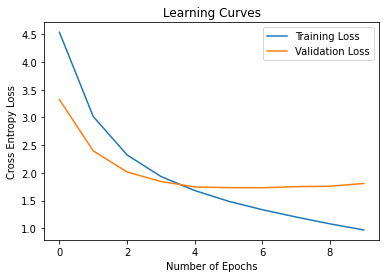

In [ ]:
plt.title('Learning Curves')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.plot(train_losses, label = 'Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Colab/NLP/Machine Translation/Plots/Conv_Seq2Seq.jpeg')
plt.show()

## Sampling

Run the cell below to load the model for sampling.

In [ ]:
seq2seq.load_state_dict(torch.load(MODEL_STORE_PATH))

<All keys matched successfully>

In [ ]:
seq2seq.eval()
test_loss = Evaluate(test_iterator, seq2seq, criterion)
print(f"Test Loss: {test_loss:.4f} | Test PPL: {math.exp(test_loss):.4f}")

Test Loss: 1.7306 | Test PPL: 5.6439


In [ ]:
def Translate(src_sentence, src_field, trg_field, model):
    ip_tensor = ipTensor(src_sentence, SOURCE_Field)
    max_len = 4 * ip_tensor.shape[1]
    with torch.no_grad():
        enc_conved, enc_combined = model.encoder(ip_tensor)
    sos_id = trg_field.vocab.stoi[trg_field.init_token]
    eos_id = trg_field.vocab.stoi[trg_field.eos_token]
    predicts = [sos_id]
    len = 1
    while len < max_len:
        input = torch.LongTensor(predicts).unsqueeze(0).to(device)
        with torch.no_grad():
            output, attention = model.decoder(input, enc_conved, enc_combined)
        predicts.append(output.argmax(2)[:, -1].item())
        len += 1
        if predicts[-1] == eos_id:
            break
    sentence = [trg_field.vocab.itos[id] for id in predicts[1:]]
    return sentence, attention

In [ ]:
ind = int(random.random()*len(test_data.examples))
example = test_data.examples[ind]
src_sentence = example.src
trg_sentence = example.trg
print("German Sentence: ", ' '.join(src_sentence))
translation, attention = Translate(src_sentence , SOURCE_Field, TARGET_Field, seq2seq)
print("Predicted Translation: ", ' '.join(translation[:-1]))
print("Actual Translation: ", ' '.join(trg_sentence))

German Sentence:  vier schwarze männer sitzen auf den stufen einer kirche .
Predicted Translation:  four black men sit on the steps of a church .
Actual Translation:  four black men are sitting on the steps of a church .


## Display Attention 

In [ ]:
def Disp_Attn(sentence, translation, attention):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    attention = attention.squeeze(0).cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='bone')
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], rotation=45)
    ax.set_yticklabels(['']+translation)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    plt.close()

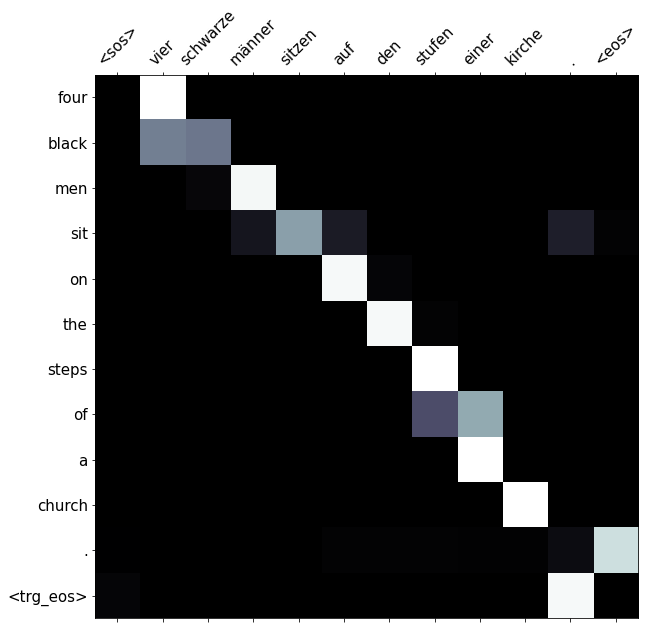

In [ ]:
Disp_Attn(src_sentence, translation, attention)

## BLEU Score

In [ ]:
def Calculate_BLEU(data, src_field, trg_field, model):
    trgs = []
    predicted_trgs = []
    for i in range(len(data.examples)):
        src_sentence = vars(data[i])['src']
        trg_sentence = vars(data[i])['trg']
        try:                                # Sometimes(rarely) CUDA throws a "Device side assert triggered" error. So, just to avoid restarting runtime.
            predicted_trg, _ = Translate(src_sentence, src_field, trg_field, model)
            predicted_trgs.append(predicted_trg[:-1])
            trgs.append([trg_sentence])
        except:
            pass
    return bleu_score(predicted_trgs, trgs)

In [ ]:
bleu_score_test = Calculate_BLEU(test_data, SOURCE_Field, TARGET_Field, seq2seq)
print(f"BLEU score on Testing Data: {bleu_score_test*100:.2f}")

BLEU score on Testing Data: 36.53
